In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy import signal
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# **Подготовка данных**

In [2]:
# Загрузим файлы
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# Посмотрим на данные
# 'ID' - это название файла с фотоплетизмограммой
# 'ЛПНП' - это целевая бинарная переменная (1 - повышенный уровень, 0 - норма)
train.head(5)

,ID,ЛПНП
0,k31__1__1,1
1,k31__5__5,0
2,k31__6__6,0
3,k31__17__17,0
4,k31__16__16,1


In [4]:
# Посмотрим на число положительных случаев
train['ЛПНП'].value_counts()

ЛПНП
1    330
0    223
Name: count, dtype: int64

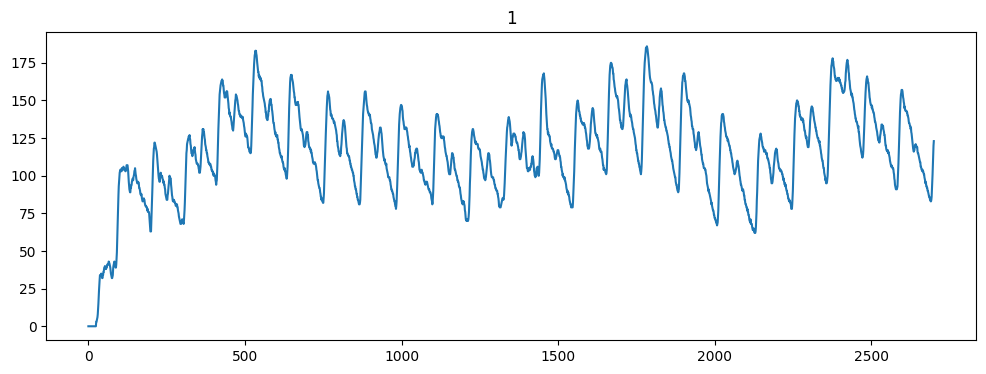

In [52]:
# Загрузим одну из фотоплетизмограмм
ind = -300

file_id = train.iloc[ind]['ID']
ill = train.iloc[ind]['ЛПНП']
path = 'data/ppgs/' + file_id + '.npy'
ppg = np.load(path)
plt.figure(figsize=(12,4))
plt.title(label=f"{ill}")
plt.plot(ppg)

In [53]:
# Разделим обучающую выборку на обучающую и валидационную часть
train, val = train_test_split(train, test_size=0.2, stratify=train['ЛПНП'], random_state=42)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

# **Создание и обучение модели**

Мы будем использовать сверточную нейронную сеть [1], созданную для работы с ЭКГ сигналами, в небольшой модификации. Она заняла первое место на соревновании PhysioNet/CinC Challenge 2021. Для ее корректной работы необходимо, чтобы длина сигнала была кратна 128.

[1] Nejedly P. et al. Classification of ECG Using Ensemble of Residual CNNs with Attention Mechanism // 2021 Computing in Cardiology (CinC). IEEE, 2021. P. 1–4. 

In [54]:
# Создадим датасет
class PPGDataset(Dataset):
    def __init__(self, df, target_col='ЛПНП', training=True):
        """
        Параметры:
            df (DataFrame): Pandas DataFrame с метаданными
            target_col (str): Название колонки с целевой переменной ('ЛПНП')
            training (bool): Флаг - тренировочный режим или нет (влияет на возвращаемые значения)
        """
        self.data = df  # DataFrame с метаданными
        self.target_col = target_col  # Название колонки с целевой переменной
        self.training = training  # Режим работы (обучение / тестирование)
        self.fs = 100  # Частота дискретизации PPG сигнала (100 Гц)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Загрузка и обработка одного образца данных по индексу
        
        Возвращает:
            Для тренировочного режима: (ppg_signal, target)
            Для тестового режима: (ppg_signal, file_id)
        """
        # Получаем строку данных по индексу
        row = self.data.iloc[idx]
        file_id = row['ID']  # Получаем идентификатор файла
        
        # Загрузка PPG сигнала из файла
        path = f'data/ppgs/{file_id}.npy'
        ppg = np.load(path)  # Загружаем PPG сигнал
        
        # Применяем bandpass фильтр (0.8-5 Гц) для удаления шумов
        b, a = signal.butter(3, [0.8 / self.fs, 5 / self.fs], 'bandpass')
        ppg = signal.filtfilt(b, a, ppg)  
        
        # Обрезаем сигнал до длины, кратной 128
        ppg = ppg[:128*20] 
        
        # Конвертируем в тензор
        ppg = torch.tensor(ppg.copy(), dtype=torch.float32).view(1, -1)
        
        # Для тренировочного режима возвращаем сигнал и целевую переменную
        if self.training:
            target = torch.tensor(row[self.target_col], dtype=torch.float32)
            return {'ppg': ppg, 'target': target}
        # Для тестового режима возвращаем сигнал и ID файла
        return {'ppg': ppg, 'file_id': file_id}

In [8]:
# Проверим работу датасета
train_dataset = PPGDataset(train, training=True)
train_dataset[0]

{'ppg': tensor([[-1.8383, -3.3219, -4.7840,  ..., 69.4044, 73.2407, 76.5227]]),
 'target': tensor(0.)}

In [55]:
# Используемая нейронная сеть
class MyResidualBlock(nn.Module):
    def __init__(self, downsample):
        super(MyResidualBlock,self).__init__()
        self.downsample = downsample
        self.stride = 2 if self.downsample else 1
        K = 9
        P = (K-1)//2
        self.conv1 = nn.Conv2d(in_channels=64,
                               out_channels=64,
                               kernel_size=(1,K),
                               stride=(1,self.stride),
                               padding=(0,P),
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels=64,
                               out_channels=64,
                               kernel_size=(1,K),
                               padding=(0,P),
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        if self.downsample:
            self.idfunc_0 = nn.AvgPool2d(kernel_size=(1,2),stride=(1,2))
            self.idfunc_1 = nn.Conv2d(in_channels=64,
                                      out_channels=64,
                                      kernel_size=(1,1),
                                      bias=False)
    def forward(self, x):
        identity = x
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        if self.downsample:
            identity = self.idfunc_0(identity)
            identity = self.idfunc_1(identity)

        x = x+identity
        return x

class PPG_NN(nn.Module):
    def __init__(self, number_of_classes):
        super(PPG_NN, self).__init__()
        self.conv = nn.Conv2d(in_channels = 1,
                              out_channels = 64,
                              kernel_size = (1, 5),
                              padding = (0, 2),
                              stride = (1, 2),
                              bias = False)

        self.bn = nn.BatchNorm2d(64)
        self.rb_0 = MyResidualBlock(downsample=True)
        self.rb_1 = MyResidualBlock(downsample=True)
        self.rb_2 = MyResidualBlock(downsample=True)
        self.rb_3 = MyResidualBlock(downsample=True)

        self.mha = nn.MultiheadAttention(64, 8)
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)

        self.classifier = nn.Linear(64, number_of_classes)


    def forward(self, x):
        x = F.leaky_relu(self.bn(self.conv(x[:, :, None, :])))

        x = self.rb_0(x)
        x = self.rb_1(x)
        x = self.rb_2(x)
        x = self.rb_3(x)

        x = F.dropout(x,p=0.5, training=self.training)

        x = x.squeeze(2).permute(2,0,1)
        x, s = self.mha(x,x,x)
        x = x.permute(1,2,0)
        x = self.pool(x).squeeze(2)

        x = self.classifier(x)
        return x

In [56]:
# Функция для обучения модели
def train_ppg_model(model, train_loader, val_loader, 
                   optimizer, criterion, epochs, device='cuda'):
    """
    Обучает модель для классификации на основе фотоплетизмограм.
    
    Параметры:
        model (torch.nn.Module): Модель для обучения
        train_loader (DataLoader): DataLoader для тренировочных данных
        val_loader (DataLoader): DataLoader для валидационных данных
        optimizer (torch.optim.Optimizer): Оптимизатор
        criterion: Функция потерь
        epochs (int): Количество эпох обучения
        device (str): Устройство для вычислений ('cuda' или 'cpu')
    
    Возвращает:
        dict: Веса модели с лучшим показателем AUC на валидации
    """
    
    # Перемещаем модель на выбранное устройство (GPU/CPU)
    model.to(device)
    
    # Инициализируем переменные для сохранения лучшей модели
    best_auc = 0.0
    best_model_state = None
    
    # Начинаем цикл обучения
    for epoch in range(epochs):
        model.train()  # Переводим модель в режим обучения
        train_loss = 0.0
        
        # Итерация по батчам тренировочных данных
        for data in train_loader:
            # Получаем PPG сигналы и целевые значения
            ppg = data['ppg'].to(device)  
            target = data['target'].to(device).float() 
            
            # Обеспечиваем правильную размерность для целевых значений
            if target.dim() == 0:
                target = target.unsqueeze(0)
            
            # Обнуляем градиенты
            optimizer.zero_grad()
            
            # Прямой проход
            outputs = model(ppg)
            
            # Приводим выходы модели и целевые значения к одинаковой форме
            outputs = outputs.view(-1)
            target = target.view(-1)
            
            # Вычисляем функцию потерь
            loss = criterion(outputs, target)
            
            # Обратный проход (вычисление градиентов)
            loss.backward()
            
            # Шаг оптимизации (обновление весов)
            optimizer.step()
            
            # Суммируем потери (умножаем на размер батча для правильного усреднения)
            train_loss += loss.item() * target.size(0)
        
        # Вычисляем среднюю потерю на эпохе
        epoch_loss = train_loss / len(train_loader.dataset)
        
        # Валидационная фаза
        model.eval()  # Переводим модель в режим оценки
        val_true, val_pred = [], []  # Для сохранения предсказаний и истинных значений
        val_loss = 0.0
        
        with torch.no_grad():  # Отключаем вычисление градиентов для валидации
            for data in val_loader:
                ppg = data['ppg'].to(device)
                target = data['target'].to(device).float()
                
                if target.dim() == 0:
                    target = target.unsqueeze(0)
                
                outputs = model(ppg)
                outputs = outputs.view(-1)
                target = target.view(-1)
                
                loss = criterion(outputs, target)
                val_loss += loss.item() * target.size(0)
                
                # Сохраняем предсказания (после логистической функции)
                val_true.append(target.detach().cpu())
                val_pred.append(torch.sigmoid(outputs.detach().cpu()))
        
        # Объединяем результаты по всем батчам
        val_true = torch.cat(val_true)
        val_pred = torch.cat(val_pred)
        
        # Вычисляем ROC AUC
        val_auc = roc_auc_score(val_true, val_pred)
        val_loss = val_loss / len(val_loader.dataset)
        
        # Сохраняем лучшую модель
        if val_auc > best_auc:
            best_auc = val_auc
            best_model_state = model.state_dict()
        
        # Выводим статистику по эпохе
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val AUC: {val_auc:.4f}, "
              f"Best val AUC: {best_auc:.4f}")

    # Возвращаем веса лучшей модели
    return best_model_state

In [58]:
# Выберем размер батча и число эпох обучения
BATCH = 10
EPOCHS = 50

# Создадим датасеты и даталоадеры
train_dataset = PPGDataset(train, training=True)
val_dataset = PPGDataset(val, training=True)
# Для тестового датасета у нас нет истинных значений предсказываемых классов
# поэтому training=False
test_dataset = PPGDataset(test, training=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

# Создадим модель, определим функцию потерь и оптимизатор
model = PPG_NN(number_of_classes=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Обучим модель
best_model_state = train_ppg_model(model=model, 
                                   train_loader=train_loader, 
                                   val_loader=val_loader, 
                                   optimizer=optimizer, 
                                   criterion=criterion,
                                   epochs=EPOCHS, 
                                   device=device)

Epoch 1/50, Train Loss: 0.6744, Val Loss: 0.6813, Val AUC: 0.5351, Best val AUC: 0.5351
Epoch 2/50, Train Loss: 0.6612, Val Loss: 0.6958, Val AUC: 0.5131, Best val AUC: 0.5351
Epoch 3/50, Train Loss: 0.6714, Val Loss: 0.6827, Val AUC: 0.5215, Best val AUC: 0.5351
Epoch 4/50, Train Loss: 0.6574, Val Loss: 0.6873, Val AUC: 0.4921, Best val AUC: 0.5351
Epoch 5/50, Train Loss: 0.6586, Val Loss: 0.6891, Val AUC: 0.4534, Best val AUC: 0.5351
Epoch 6/50, Train Loss: 0.6665, Val Loss: 0.6860, Val AUC: 0.4465, Best val AUC: 0.5351
Epoch 7/50, Train Loss: 0.6645, Val Loss: 0.6866, Val AUC: 0.4984, Best val AUC: 0.5351
Epoch 8/50, Train Loss: 0.6647, Val Loss: 0.6848, Val AUC: 0.5079, Best val AUC: 0.5351
Epoch 9/50, Train Loss: 0.6652, Val Loss: 0.6891, Val AUC: 0.4754, Best val AUC: 0.5351
Epoch 10/50, Train Loss: 0.6549, Val Loss: 0.6857, Val AUC: 0.5010, Best val AUC: 0.5351
Epoch 11/50, Train Loss: 0.6460, Val Loss: 0.6895, Val AUC: 0.4838, Best val AUC: 0.5351
Epoch 12/50, Train Loss: 0.657

In [59]:
# Сделаем предсказания для тестовой выборки
model.load_state_dict(best_model_state)
model.eval()
test_preds = []
test_ids = []

with torch.no_grad():
    for data in test_loader:
        ppg = data['ppg'].to(device)
        file_id = data['file_id']
        outputs = model(ppg).view(-1)
        probs = torch.sigmoid(outputs).cpu().numpy()
        test_preds.extend(probs)
        test_ids.extend(file_id)

# Создадим датафрейм
result_df = pd.DataFrame({
    'ID': test_ids,
    'ЛПНП': test_preds
})
test_predictions = test.merge(result_df, on='ID', how='left')

In [60]:
# Убедимся, что датафрейм с предсказаниями, имеет нужный формат
test_predictions.head()

,ID,ЛПНП
0,k31__2__2,0.430115
1,k31__0__0,0.473746
2,k31__13__13,0.421687
3,k31__14__14,0.501944
4,k31__25__25,0.640665


In [61]:
# Сохраним датафрейм с предсказаниями
test_predictions.to_csv('./outputs/baseline_submit.csv', index=False)